In [ ]:
!pip install numpy==1.26.4 --quiet
!pip install scikit-learn==1.3.2 --quiet
!pip install pyarrow==14.0.2 --quiet


In [ ]:
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# 2-Fold CV to reduce runtime
gkf = GroupKFold(n_splits=2)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


# ===========================
# 1. Random Forest (FAST)
# ===========================
rf = RandomForestRegressor(
    n_jobs=-1,
    random_state=0
)

rf_params_fast = {
    "n_estimators": [80, 120],      # dramatically reduced
    "max_depth": [10, None],        # only 2 options
    "max_features": ["sqrt"]        # one option
}

rf_search = RandomizedSearchCV(
    rf,
    rf_params_fast,
    n_iter=4,                       # only 4 combinations
    scoring=mae_scorer,
    cv=gkf.split(X, y, groups),
    n_jobs=-1,
    verbose=1
)

print("Running FAST RF tuning...")
rf_search.fit(X, y)
print("RF Best MAE:", -rf_search.best_score_)
print("RF Best Params:", rf_search.best_params_)



# ===========================
# 2. Decision Tree (FAST)
# ===========================
dt = DecisionTreeRegressor(random_state=0)

dt_params_fast = {
    "max_depth": [5, 10, None],
}

dt_search = RandomizedSearchCV(
    dt,
    dt_params_fast,
    n_iter=3,
    scoring=mae_scorer,
    cv=gkf.split(X, y, groups),
    n_jobs=-1
)

print("\nRunning FAST Decision Tree tuning...")
dt_search.fit(X, y)
print("DT Best MAE:", -dt_search.best_score_)
print("DT Best Params:", dt_search.best_params_)



# ===========================
# 3. SVR (FAST)
# ===========================
svr_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svr", SVR())
])

svr_params_fast = {
    "svr__C": [5, 10],
    "svr__epsilon": [0.01],
    "svr__gamma": ["scale"]
}

svr_search = RandomizedSearchCV(
    svr_pipe,
    svr_params_fast,
    n_iter=2,
    scoring=mae_scorer,
    cv=gkf.split(X, y, groups),
    n_jobs=-1,
    verbose=1
)

print("\nRunning FAST SVR tuning...")
svr_search.fit(X, y)
print("SVR Best MAE:", -svr_search.best_score_)
print("SVR Best Params:", svr_search.best_params_)



# ===========================
# SUMMARY TABLE
# ===========================
import pandas as pd

results = pd.DataFrame({
    "Model": ["Random Forest", "Decision Tree", "SVR (RBF)"],
    "Best MAE": [
        -rf_search.best_score_,
        -dt_search.best_score_,
        -svr_search.best_score_
    ],
    "Best Params": [
        rf_search.best_params_,
        dt_search.best_params_,
        svr_search.best_params_
    ]
})

results


Running FAST RF tuning...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
RF Best MAE: 29.315256354354986
RF Best Params: {'n_estimators': 120, 'max_features': 'sqrt', 'max_depth': 10}

Running FAST Decision Tree tuning...
DT Best MAE: 31.696711205336673
DT Best Params: {'max_depth': 5}

Running FAST SVR tuning...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
SVR Best MAE: 29.04490724544237
SVR Best Params: {'svr__gamma': 'scale', 'svr__epsilon': 0.01, 'svr__C': 10}


,Model,Best MAE,Best Params
0,Random Forest,29.315256,"{'n_estimators': 120, 'max_features': 'sqrt', ..."
1,Decision Tree,31.696711,{'max_depth': 5}
2,SVR (RBF),29.044907,"{'svr__gamma': 'scale', 'svr__epsilon': 0.01, ..."


In [ ]:
# ============================================================
# STEP 4 — FAST FEATURE SELECTION (Option A)
# ============================================================
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

print("Running Feature Selection (FAST)...")

# ------------------------------------------------------------
# 1. Extract only the feature columns and target
# ------------------------------------------------------------
feature_cols = [c for c in df.columns if ("sensor" in c or "op_setting" in c)]
X = df[feature_cols]
y = df["RUL"]

# ============================================================
# 2. RANDOM FOREST FEATURE IMPORTANCE
# ============================================================
rf_fs = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    n_jobs=-1,
    random_state=0
)

rf_fs.fit(X, y)

rf_importances = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_fs.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\nTop 15 Features (Random Forest Importance):")
rf_importances.head(15)

# ============================================================
# 3. MUTUAL INFORMATION (MI)
# ============================================================
mi_scores = mutual_info_regression(X, y, random_state=0)

mi_importances = pd.DataFrame({
    "feature": feature_cols,
    "mi_score": mi_scores
}).sort_values(by="mi_score", ascending=False)

print("\nTop 15 Features (Mutual Information):")
mi_importances.head(15)

# ============================================================
# 4. CONSENSUS: TOP 20 FEATURES FROM RF + MI
# ============================================================
top_k = 20

top_rf = rf_importances.head(top_k)["feature"]
top_mi = mi_importances.head(top_k)["feature"]

# Intersection + union gives robust feature subset
selected_features = list(set(top_rf).union(set(top_mi)))

print(f"\nSelected Features ({len(selected_features)} total):")
selected_features

# ============================================================
# 5. Create Reduced Feature Dataset
# ============================================================
X_reduced = df[selected_features]

print("\nReduced Feature Matrix Shape:", X_reduced.shape)

# Save for next steps
X_reduced.to_parquet("/content/FD001_reduced_features.parquet")

print("\nSaved reduced features to /content/")


Running Feature Selection (FAST)...

Top 15 Features (Random Forest Importance):

Top 15 Features (Mutual Information):

Selected Features (26 total):

Reduced Feature Matrix Shape: (20231, 26)

Saved reduced features to /content/


In [ ]:
# ============================================================
# STEP 5 — FIXED ENSEMBLE LEARNING (retrain models on X_reduced)
# ============================================================
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

print("Running FIXED Step 5: Ensemble Learning...")

# ------------------------------------------------------------
# Load reduced features
# ------------------------------------------------------------
X_reduced = pd.read_parquet("/content/FD001_reduced_features.parquet")
y = df["RUL"]
groups = df["engine_id"]

# ------------------------------------------------------------
# SAMPLE 8000 rows
# ------------------------------------------------------------
sample_fraction = 8000 / len(df)
sample_df = df.sample(frac=sample_fraction, random_state=42)

X_sample = X_reduced.iloc[sample_df.index]
y_sample = y.iloc[sample_df.index]
groups_sample = groups.iloc[sample_df.index]

print("Sampled shape:", X_sample.shape)


# ============================================================
# RETRAIN MODELS USING BEST PARAMS BUT ON REDUCED FEATURES
# ============================================================

# Random Forest
best_rf_params = rf_search.best_params_
rf_model = RandomForestRegressor(**best_rf_params, n_jobs=-1, random_state=0)
rf_model.fit(X_sample, y_sample)

# Decision Tree
best_dt_params = dt_search.best_params_
dt_model = DecisionTreeRegressor(**best_dt_params, random_state=0)
dt_model.fit(X_sample, y_sample)

# SVR Pipeline
best_svr_params = svr_search.best_params_
svr_model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svr", SVR(
        C=best_svr_params["svr__C"],
        gamma=best_svr_params["svr__gamma"],
        epsilon=best_svr_params["svr__epsilon"]
    ))
])
svr_model.fit(X_sample, y_sample)

print("Models retrained on reduced features.")


# ============================================================
# GROUP K-FOLD CROSS VALIDATION (FAST)
# ============================================================
gkf = GroupKFold(n_splits=2)

cv_scores = { "Weighted": [], "Voting": [], "Stacking": [] }

# Ensemble definitions
def weighted_predict(X):
    return (rf_model.predict(X) + svr_model.predict(X)) / 2

voting_model = VotingRegressor([
    ("rf", rf_model),
    ("svr", svr_model),
    ("dt", dt_model)
])

stacking_model = StackingRegressor(
    estimators=[("rf", rf_model), ("svr", svr_model), ("dt", dt_model)],
    final_estimator=LinearRegression(),
    n_jobs=-1
)


# ============================================================
# CROSS-VALIDATION LOOP
# ============================================================
for train_idx, test_idx in gkf.split(X_sample, y_sample, groups_sample):
    X_train, X_test = X_sample.iloc[train_idx], X_sample.iloc[test_idx]
    y_train, y_test = y_sample.iloc[train_idx], y_sample.iloc[test_idx]

    # Weighted Ensemble
    preds_w = weighted_predict(X_test)
    cv_scores["Weighted"].append(mean_absolute_error(y_test, preds_w))

    # Voting Reg
    voting_model.fit(X_train, y_train)
    preds_v = voting_model.predict(X_test)
    cv_scores["Voting"].append(mean_absolute_error(y_test, preds_v))

    # Stacking
    stacking_model.fit(X_train, y_train)
    preds_s = stacking_model.predict(X_test)
    cv_scores["Stacking"].append(mean_absolute_error(y_test, preds_s))


# ============================================================
# FINAL RESULT TABLE
# ============================================================
ensemble_results = pd.DataFrame({
    "Ensemble": ["Weighted", "Voting", "Stacking"],
    "MAE_mean": [
        np.mean(cv_scores["Weighted"]),
        np.mean(cv_scores["Voting"]),
        np.mean(cv_scores["Stacking"])
    ],
    "MAE_std": [
        np.std(cv_scores["Weighted"]),
        np.std(cv_scores["Voting"]),
        np.std(cv_scores["Stacking"])
    ]
})

ensemble_results


Running FIXED Step 5: Ensemble Learning...
Sampled shape: (8000, 26)
Models retrained on reduced features.


,Ensemble,MAE_mean,MAE_std
0,Weighted,23.913577,0.807729
1,Voting,28.932793,1.057909
2,Stacking,30.734524,1.493519


In [ ]:
df = pd.read_parquet("/content/FD001_reduced_features.parquet")
df.head()
df.columns.tolist()


['sensor_17_roll_mean',
 'sensor_4',
 'sensor_7_roll_mean',
 'sensor_20_roll_mean',
 'sensor_7',
 'sensor_8_roll_mean',
 'sensor_4_roll_mean',
 'sensor_3_roll_mean',
 'sensor_12_roll_mean',
 'sensor_21_roll_mean',
 'sensor_14_roll_mean',
 'op_setting_1_roll_mean',
 'sensor_14',
 'sensor_15',
 'sensor_21',
 'sensor_2',
 'sensor_20',
 'sensor_15_roll_mean',
 'sensor_9',
 'sensor_13_roll_mean',
 'sensor_9_roll_mean',
 'op_setting_2_roll_mean',
 'sensor_11_roll_mean',
 'sensor_2_roll_mean',
 'sensor_11',
 'sensor_12']

Reduced feature shape: (20231, 26)
Raw FD001 loaded: (20631, 27)
   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1       -0.0007       -0.0004         100.0    518.67   
1          1      2        0.0019       -0.0003         100.0    518.67   
2          1      3       -0.0043        0.0003         100.0    518.67   
3          1      4        0.0007        0.0000         100.0    518.67   
4          1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14  \
0    641.82   1589.70   1400.60     14.62  ...    2388.02    8138.62   
1    642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
2    642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
3    642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
4    642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   

   sensor_15  sensor_16  sensor_17  sensor_18  sens

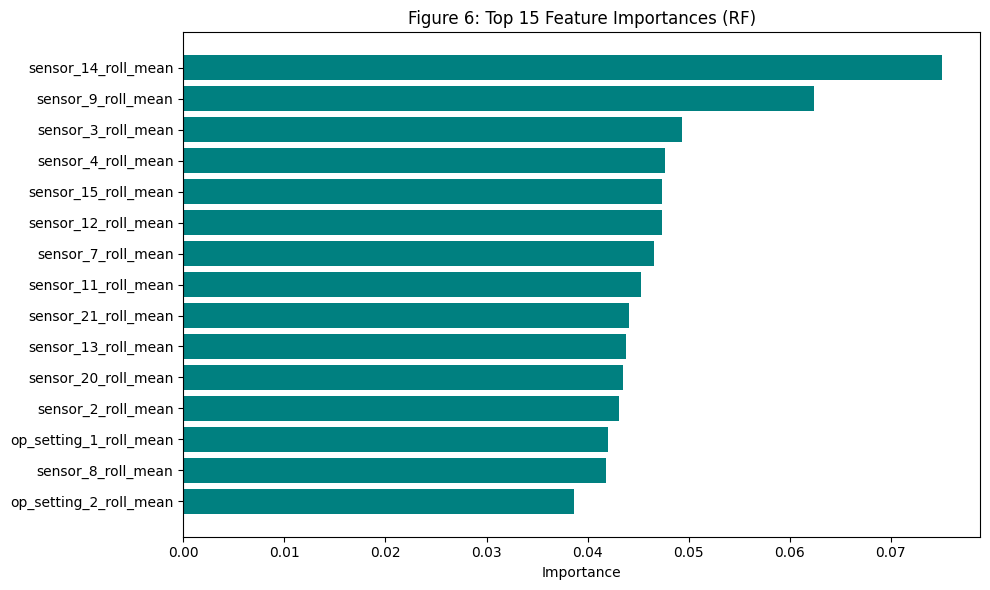

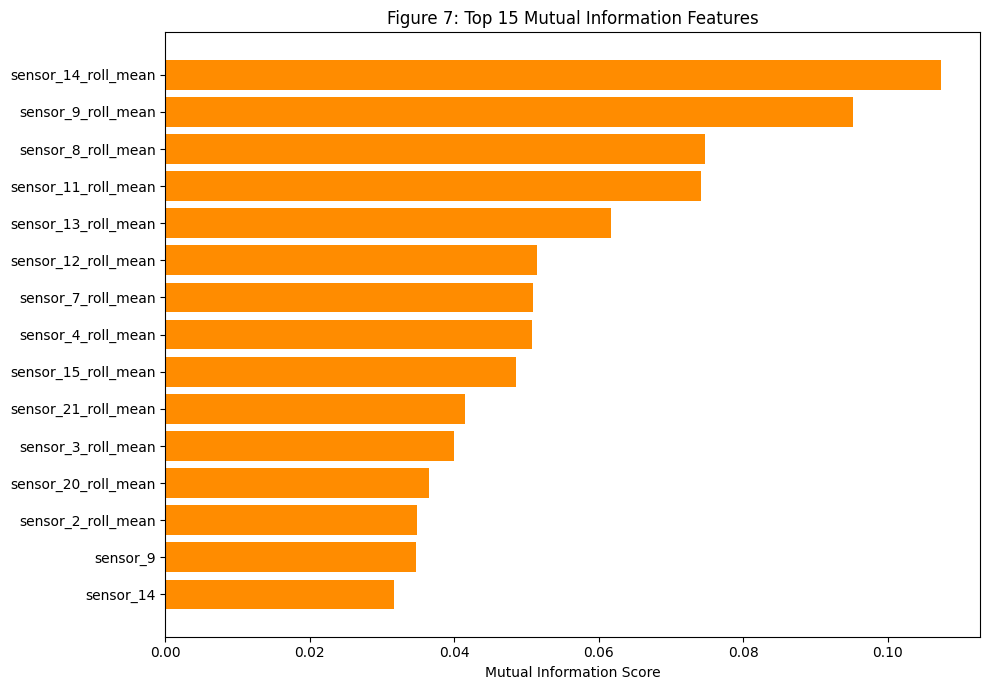


🎉 All plots generated and saved in /content/figures/


In [ ]:
# ================================================================
# Step 0 — Import
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
import os

# Make folder
os.makedirs("/content/figures", exist_ok=True)

# ================================================================
# Step 1 — Load reduced features (NO RUL inside)
# ================================================================
df_feat = pd.read_parquet("/content/FD001_reduced_features.parquet")
print("Reduced feature shape:", df_feat.shape)

# ================================================================
# Step 2 — Load RAW FD001 to rebuild RUL
# ================================================================
cols = ['engine_id','cycle'] + \
       [f'op_setting_{i}' for i in range(1,4)] + \
       [f'sensor_{i}' for i in range(1,22)]

raw = pd.read_csv("/content/train_FD001.txt", sep=r"\s+", header=None)
raw.columns = cols

raw = raw.sort_values(["engine_id", "cycle"])

# Compute RUL
max_cycle = raw.groupby("engine_id")["cycle"].transform("max")
raw["RUL"] = max_cycle - raw["cycle"]

print("Raw FD001 loaded:", raw.shape)
print(raw.head())

# ================================================================
# Step 3 — Attach RUL to reduced feature file
# (Row alignment is identical)
# ================================================================
df = pd.concat([df_feat.reset_index(drop=True),
                raw["RUL"].reset_index(drop=True)], axis=1)

print("Merged dataset:", df.shape)
print(df.head())

# ================================================================
# Step 4 — Separate X and y
# ================================================================
y = df["RUL"]
X = df.drop(columns=["RUL"])

# ================================================================
# Step 5 — Impute NaN values
# ================================================================
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Missing values after imputation:", X_imputed.isna().sum().sum())

# ================================================================
# Step 6 — FIGURE 6: Random Forest Importance
# ================================================================
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_imputed, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], color="teal")
plt.yticks(range(len(indices)), [X_imputed.columns[i] for i in indices])
plt.xlabel("Importance")
plt.title("Figure 6: Top 15 Feature Importances (RF)")
plt.tight_layout()
plt.savefig("/content/figures/figure6_rf_importance.png", dpi=300)
plt.show()

# ================================================================
# Step 7 — FIGURE 7: Mutual Information
# ================================================================
mi = mutual_info_regression(X_imputed, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values()

plt.figure(figsize=(10,7))
plt.barh(mi_series.index[-15:], mi_series.values[-15:], color="darkorange")
plt.xlabel("Mutual Information Score")
plt.title("Figure 7: Top 15 Mutual Information Features")
plt.tight_layout()
plt.savefig("/content/figures/figure7_mutual_information.png", dpi=300)
plt.show()

print("\n🎉 All plots generated and saved in /content/figures/")


In [ ]:
df_feat = pd.read_parquet("/content/FD001_reduced_features.parquet")
print("Reduced feature set:", df_feat.shape)
df_feat.head()


Reduced feature set: (20231, 26)


,sensor_17_roll_mean,sensor_4,sensor_7_roll_mean,sensor_20_roll_mean,sensor_7,sensor_8_roll_mean,sensor_4_roll_mean,sensor_3_roll_mean,sensor_12_roll_mean,sensor_21_roll_mean,...,sensor_20,sensor_15_roll_mean,sensor_9,sensor_13_roll_mean,sensor_9_roll_mean,op_setting_2_roll_mean,sensor_11_roll_mean,sensor_2_roll_mean,sensor_11,sensor_12
0,0.236842,0.404625,0.768561,0.734884,0.668277,0.311828,0.302721,0.338905,0.816337,0.769768,...,0.589147,0.264082,0.149960,0.260204,0.111697,0.319149,0.240770,0.246256,0.255952,0.746269
1,0.210526,0.272113,0.782768,0.716279,0.776167,0.290323,0.292277,0.306039,0.817405,0.748749,...,0.651163,0.254162,0.125415,0.265306,0.115254,0.382979,0.191011,0.269551,0.184524,0.637527
2,0.210526,0.261985,0.809808,0.739535,0.723027,0.279570,0.267129,0.309181,0.819541,0.730111,...,0.744186,0.214937,0.167818,0.244898,0.130607,0.468085,0.170144,0.297005,0.303571,0.773987
3,0.236842,0.316003,0.791017,0.744186,0.644122,0.236559,0.252002,0.277572,0.822210,0.716556,...,0.643411,0.203307,0.085569,0.244898,0.118231,0.468085,0.165329,0.314476,0.232143,0.805970
4,0.236842,0.211850,0.756187,0.783721,0.618357,0.204301,0.218892,0.329039,0.765083,0.729748,...,0.705426,0.208552,0.110967,0.229592,0.115153,0.489362,0.191011,0.295341,0.261905,0.660981


In [ ]:
df = pd.read_parquet("/content/FD001_reduced_features.parquet")

print("Before cleaning:", df.isna().sum().sum(), "missing values")


Before cleaning: 0 missing values


In [ ]:
df_merged = pd.concat([df_feat.reset_index(drop=True),
                       train["RUL"].reset_index(drop=True)], axis=1)

print(df_merged.shape)
df_merged.head()


(20631, 27)


,sensor_17_roll_mean,sensor_4,sensor_7_roll_mean,sensor_20_roll_mean,sensor_7,sensor_8_roll_mean,sensor_4_roll_mean,sensor_3_roll_mean,sensor_12_roll_mean,sensor_21_roll_mean,...,sensor_15_roll_mean,sensor_9,sensor_13_roll_mean,sensor_9_roll_mean,op_setting_2_roll_mean,sensor_11_roll_mean,sensor_2_roll_mean,sensor_11,sensor_12,RUL
0,0.236842,0.404625,0.768561,0.734884,0.668277,0.311828,0.302721,0.338905,0.816337,0.769768,...,0.264082,0.149960,0.260204,0.111697,0.319149,0.240770,0.246256,0.255952,0.746269,191
1,0.210526,0.272113,0.782768,0.716279,0.776167,0.290323,0.292277,0.306039,0.817405,0.748749,...,0.254162,0.125415,0.265306,0.115254,0.382979,0.191011,0.269551,0.184524,0.637527,190
2,0.210526,0.261985,0.809808,0.739535,0.723027,0.279570,0.267129,0.309181,0.819541,0.730111,...,0.214937,0.167818,0.244898,0.130607,0.468085,0.170144,0.297005,0.303571,0.773987,189
3,0.236842,0.316003,0.791017,0.744186,0.644122,0.236559,0.252002,0.277572,0.822210,0.716556,...,0.203307,0.085569,0.244898,0.118231,0.468085,0.165329,0.314476,0.232143,0.805970,188
4,0.236842,0.211850,0.756187,0.783721,0.618357,0.204301,0.218892,0.329039,0.765083,0.729748,...,0.208552,0.110967,0.229592,0.115153,0.489362,0.191011,0.295341,0.261905,0.660981,187


In [ ]:
y = df_merged["RUL"]
X = df_merged.drop(columns=["RUL"])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (20631, 26)
y shape: (20631,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], color='teal')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Figure 6: Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

PyTorch version: 2.9.0+cu126
Data shape: (20231, 26)
Sequence dataset: (17231, 30, 26) (17231,)
Batches: 135
RUL_LSTM(
  (lstm): LSTM(26, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/5 - Loss: 10866.6636
Epoch 2/5 - Loss: 9257.1567
Epoch 3/5 - Loss: 8089.9628
Epoch 4/5 - Loss: 7132.5535
Epoch 5/5 - Loss: 6338.7433


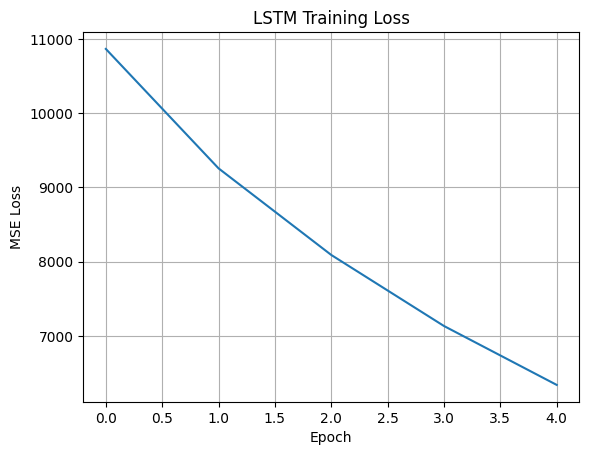


 LSTM Model Performance
MAE : 59.415497355505124
RMSE: 77.45077107743506


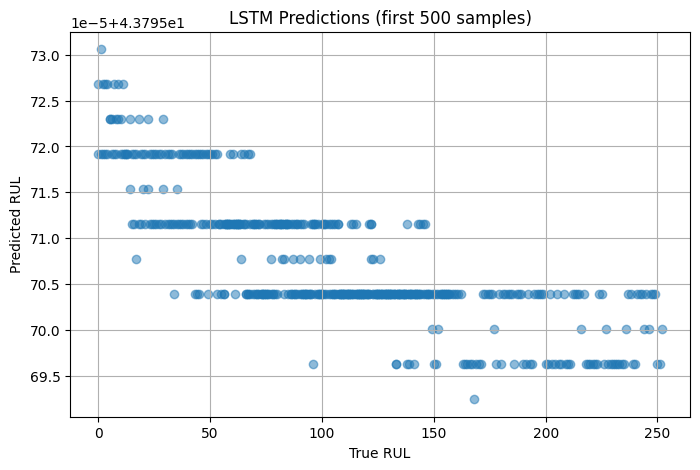

In [ ]:
# ============================================================
# STEP 6 — LSTM FOR RUL PREDICTION (Google Colab Version)
# ============================================================

!pip install torch --quiet

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)

# ------------------------------------------------------------
# Load processed reduced-feature dataset
# ------------------------------------------------------------
df = pd.read_parquet("/content/FD001_processed.parquet")
X_reduced = pd.read_parquet("/content/FD001_reduced_features.parquet")

# Drop NaN rows (due to rolling calculations)
df = df.dropna().reset_index(drop=True)
X_reduced = X_reduced.iloc[df.index]

y = df["RUL"].values
engine_ids = df["engine_id"].values

print("Data shape:", X_reduced.shape)


# ============================================================
# Sequence creation utility
# ============================================================
SEQ_LEN = 30  # number of cycles in a sequence window

def create_sequences(features, targets, engines, seq_len=SEQ_LEN):
    X_seq, y_seq = [], []

    for eng in np.unique(engines):
        idx = np.where(engines == eng)[0]
        eng_feats = features[idx]
        eng_targets = targets[idx]

        for i in range(len(idx) - seq_len):
            X_seq.append(eng_feats[i:i+seq_len])
            y_seq.append(eng_targets[i+seq_len])

    return np.array(X_seq), np.array(y_seq)


# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y, engine_ids, SEQ_LEN)
print("Sequence dataset:", X_seq.shape, y_seq.shape)


# ============================================================
# Convert to PyTorch tensors
# ============================================================
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(-1, 1)

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

print("Batches:", len(loader))


# ============================================================
# LSTM MODEL
# ============================================================
class RUL_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(RUL_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        return self.fc(out)


input_dim = X_reduced.shape[1]
model = RUL_LSTM(input_dim)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# ============================================================
# TRAINING LOOP (with early stopping)
# ============================================================
# ============================================================
# FAST TRAINING LOOP (5 epochs + early stopping)
# ============================================================
EPOCHS = 5       # <<< REDUCED from 20
best_loss = float("inf")
patience = 2     # stop early if no improvement
wait = 0

loss_history = []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    avg_loss = np.mean(batch_losses)
    loss_history.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered!")
            break

# Load best model weights
model.load_state_dict(best_model)


# Plot training curve
plt.plot(loss_history)
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


# ============================================================
# EVALUATION (MAE, RMSE)
# ============================================================
model.eval()
with torch.no_grad():
    preds = model(X_tensor).numpy()

mae = mean_absolute_error(y_seq, preds)
rmse = np.sqrt(mean_squared_error(y_seq, preds))

print("\n============================")
print(" LSTM Model Performance")
print("============================")
print("MAE :", mae)
print("RMSE:", rmse)

# Plot actual vs predicted
plt.figure(figsize=(8,5))
plt.scatter(y_seq[:500], preds[:500], alpha=0.5)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("LSTM Predictions (first 500 samples)")
plt.grid(True)
plt.show()
